<a href="https://colab.research.google.com/github/All4Nothing/pytorch-DL-programming/blob/main/Ch10_DL_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

In [2]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

# 10. 튜닝 기법

In [1]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [2]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [3]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [4]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# 분류 클래스 명칭 리스트
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 분류 클래스 수,　10
n_output = len(list(set(classes)))

# 결과 확인
print(n_output)

10


**이미지 인식 딥러닝 분류 모델의 튜닝 기법**
- 신경망의 다층화
- 최적화 함수의 개선
- 과학습에 관한 대책
  - 드롭아웃
  - 배치 정규화
  - 데이터 증강

## 10.3 최적화 함수

최적화 함수란, 손실의 경사 값(편미분의 계산 결과)을 기반으로, 어떤 알고리즘을 통해 파라미터를 수정해 나갈 것인지에 관한 방식을 일컫는다.
최적화 함수에 따라 학습 속도와 정확도가 달라질 수 있다.

### SGD(Stochastic Gradient Descent)
전체 데이터가 아닌, 일부 데이터에 대해 경사값을 계산 후 일정한 학습률을 곱해서 파라미터를 수정해 나간다.

In [6]:
# 학습률
# lr = 0.001

# 경사를 기반으로 파라미터 갱신
# W -= lr * W.grad
# B -= lr * B.grad

### 모멘텀(Momentum)
SGD를 개선하기 위해 인수로 모멘텀 인수를 설정하는 방법이 있다.  
SGD는 이전 이동 정도를 반영하여(관성) 이동한다. Smooth하게 움직이는 효과 ex. 이전 이동의 90% + 현재 gradeint

In [7]:
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum = 0.9)

### Adam

이전 이동 정도(Momentum)와 과거 움직임 정도를 반영한 학습률(Adaptive Learning Factor)

In [8]:
# optimizer = optim.Adam(net.parameters())

## 10.4 과학습의 대응 방법

경사 하강법은 훈련 데이터의 손실을 줄이기 위한 알고리즘으로, 훈련을 반복할 수록 훈련 데이터의 손실은 줄어든다. 하지만, 머신러닝의 근본적인 목적은, 학습에 사용하지 않은 검증 데이터에 대해 정확도를 향상시키는 것이다.  
과학습이란 훈련 데이터로만 최적화를 시킨 나머지, 검증 데이터에 대해서는 정확도가 더 이상 올라가지 않는, 또는 오히려 모델이 악화되는 현상을 가리킨다.

### 드롭아웃(Dropout)  
1. 신경망을 정의할 때, 2개의 레이어 함수 사이에 드롭아웃 함수를 추가한다. 드롭아웃 함수의 인스턴스를 생성할 때, '드롭아웃 비율'을 파라미터로 설정한다.  
2. 학습이 진행됨에 따라 설정한 드롭아웃 비율만큼, 드롭아웃 함수로 입력되는 중간 텐서에서 랜덤하게 드롭아웃의 대상이 선정되고, 그 요소를 더 이상 출력하지 않는다.(= 출구를 막은 터널,= 일부 텐서 요소를 제외하고 학습이 진행되는 상태)
3. 다음의 학습 반복에서 새로운 난수로 인해 중간 텐서의 다른 요소가 드롭아웃의 대상으로 선정된다. 그 다음의 반복에 관해서도 마찬가지다.
4. 학습이 완료된 이후, 예측 페이즈에서는 드롭아웃 상태를 없애고 모든 텐서 요소가 관여하도록 예측한다.
![dropout](https://wikidocs.net/images/page/152777/222222222.JPG)

In [9]:
# 드랍 아웃 실험용 더미 데이터 작성

torch.manual_seed(123)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [10]:
# 드랍 아웃 함수 정의
dropout = nn.Dropout(0.5) ## 0.5 : dropout 비율

# 훈련 페이즈에서의 거동
dropout.train() ## train 함수 호출 → 훈련 페이즈로 인스턴스 설정
print(dropout.training)
outputs = dropout(inputs)
print(outputs) ## 10개의 입력 중 5개의 요소가 0이 됨
## 0이 아닌 요소들은, 드롭아웃 비율을 p로 설정했을 때, 출력은 1/(1-p)를 곱한 값이 반환된다. 이것은 입력값 전체 평균이 드롭아웃 이전과 변하지 않게 하기 위함이다.

# 예측 페이즈에서의 거동
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[-0.0000,  0.2407, -0.0000, -0.4808, -0.0000,  0.0000, -1.9447, -0.0000,
          0.6478, -0.2170]])
False
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


**model.train(), model.eval()**  
PyTorch에서 제공하는 nn.Module은 모델을 훈련 모드와 평가 모드로 전환하는 메서드이다. 즉, train time과 evaluate time에 수행다는 다른 작업을 switching해줄 수 있도록 하는 함수를 제공한다.
model.eval()을 호출하면 모델이 평가 모드로 전환된다. 모델이 평가 모드로 전환되면, `dropout layer`와 `BatchNorm layer`와 같이 train time과 evaluate time에서 서로 다르게 동작해야 하는 것들을 스위칭 해준다. ex) eval에서는 드롭아웃이 비활성화되고 배치 정규화의 이동 평균과 이동 분산이 업데이트되지 않습니다.
평가 모드에서는 모델이 추론 시에 동일한 동작을 수행하도록 설정되어 있어, 모델의 성능 평가에 불필요한 노이즈를 줄이고 일관된 결과를 얻을 수 있습니다.
모델을 학습(training)하는 동안 사용한 모델 객체를 추론(inference)할 때 model.eval()을 호출하여 추론 모드로 전환하고, 추론이 끝난 후에는 다시 model.train()을 호출하여 학습 모드로 전환하는 것이 일반적입니다.

### 배치 정규화(Batch Normalization)  
미니 배치 학습법에서, 전 레이어 함수의 출력을 미니 배치 단위로 정규화 처리를 거친 다음, 이어지는 레이어 함수로 입력하면 학습의 효율이 향상됨과 동시에 과학습을 예방할 수 있다.

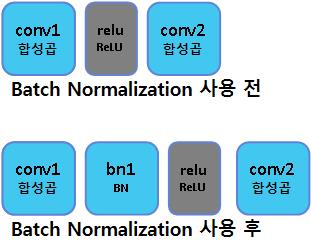

- 합성곱 연산 주에는 nn.BatchNorm2d를, 선형 함수의 바로 뒤에는 nn.BatchNorm1d를 사용한다.
- 인스턴스 생성 시에는 정수 파라미터가 한 개 필요하다. nn.BatchNorm2d를 사용할 때는 입력 데이터의 채널 수, nn.BatchNorm1d를 사용할 때는 입력 데이터의 차원수가 그 값이다.
- 학습 대상 파라미터인 weight와 bias를 가지고 있다.
- 드롭아웃 함수와 마찬가지로 훈련 페이즈와 예측 페이즈에서 거동이 서로 다르다.

### 데이터 증강(Data Augmentation)  
학습 전 입력 데이터를 인위적으로 가공해서 학습 데이터의 다양성을 증가시키는 방법이다.  
모델의 관점에서는 학습을 반복할 때마다 다른 패턴의 데이터가 들어오기 때문에, 과학습이 일어나기 힘든 것이다.  
PyTorch의 Transforms(데이터 전처리)는 데이터 증강을 위한 가공 기능을 제공한다.

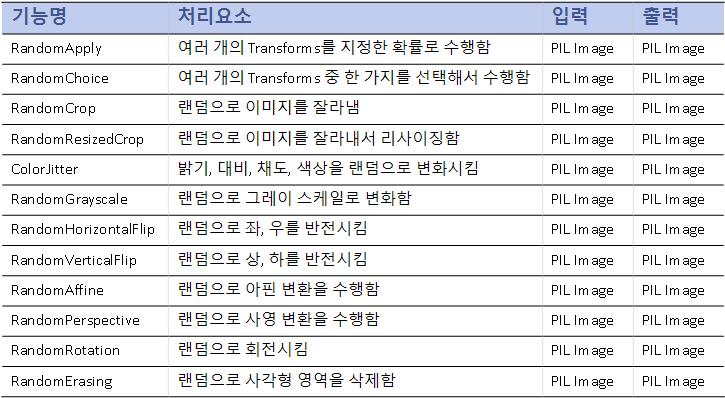

*표 10-1 파이토치에서 데이터 증강을 목적으로 사용 가능한 기능 목록*

In [11]:
# 훈련 데이터용: 정규화에 추가로 반전과 RandomErasing 수행
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # PIL Image → PIL Image
    transforms.ToTensor(), # PIL Image → Tensor. input image를 텐서로 바꿔주기 위함
    transforms.Normalize(0.5, 0.5), # Tensor → Tensor
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

## 10.5 공통 함수의 라이브러리화

In [12]:
# 공통 함수 다운로드
!git clone https://github.com/wikibook/pythonlibs.git

# 공통 함수 불러오기
from pythonlibs.torch_lib1 import *

# 공통 함수 확인
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 25 (delta 6), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (25/25), 21.10 MiB | 7.01 MiB/s, done.
Common Library for PyTorch
Author: M. Akaishi


pythonlibs.torch_lib1 \_\_init\_\_.py
```
# 공통 함수 정의
# Apache License Version 2.0
# https://www.apache.org/licenses/LICENSE-2.0.html

# ReadMe
README = 'Common Library for PyTorch\nAuthor: M. Akaishi'

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from tqdm.notebook import tqdm

# 손실 함수 계산
def eval_loss(loader, device, net, criterion):
  
    # 데이터로더에서 처음 한 세트 가져오기
    for images, labels in loader:
        break

    # 디바이스 할당
    inputs = images.to(device)
    labels = labels.to(device)

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    return loss
  

# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 함수
            outputs = net(inputs)

            # 손실 함수
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        # 예측 페이즈
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history



# 학습 로그 해석
def evaluate_history(history):
  # 손실과 정확도 확인
  print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}')
  print(f'최종상태 : 손실 : {history[-1,3]:.5f} 정확도 : {history[-1,4]:.5f}' )

  num_epochs = len(history)
  if num_epochs < 10:
    unit = 1
  else:
    unit = num_epochs / 10

  # 학습 곡선 출력(손실)
  plt.figure(figsize=(9,8))
  plt.plot(history[:,0], history[:,1], 'b', label='훈련')
  plt.plot(history[:,0], history[:,3], 'k', label='검증')
  plt.xticks(np.arange(0,num_epochs+1, unit))
  plt.xlabel('반복 횟수')
  plt.ylabel('손실')
  plt.title('학습 곡선(손실)')
  plt.legend()
  plt.show()

  # 학습 곡선 출력(정확도)
  plt.figure(figsize=(9,8))
  plt.plot(history[:,0], history[:,2], 'b', label='훈련')
  plt.plot(history[:,0], history[:,4], 'k', label='검증')
  plt.xticks(np.arange(0,num_epochs+1,unit))
  plt.xlabel('반복 횟수')
  plt.ylabel('정확도')
  plt.title('학습 곡선(정확도)')
  plt.legend()
  plt.show()


# 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 처음 한 세트 가져오기
    for images, labels in loader:
        break
    # 표시 수는 50개
    n_size = min(len(images), 50)

    if net is not None:
      # 디바이스 할당
      inputs = images.to(device)
      labels = labels.to(device)

      # 예측 계산
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 처음 n_size개 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net이 None이 아닌 경우는 예측 결과도 타이틀에 표시
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 정답 여부를 색으로 나타냄
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net이 None인 경우는 정답 라벨만을 표시
        else:
          ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이 배열로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경(channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
        img = (img + 1)/2
        # 결과 출력
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
```



이 방법을 통해 공통 함수를 정의할 때는 2가지를 주의해야 한다.  
- 라이브러리는 공통 함수 쪽에서도 동일한 것을 import 한다.  
- 호출해오는 쪽(\_\_init\_\_.py)에서 사용 중인 모든 변수는 모두 함수의 파라미터로 넘겨주도록 한다.

**자기만의 공통 함수를 만들어보는 것도 좋다.**

## 10.6 층을 깊게 쌓은 모델 구현하기

In [13]:
# Transforms의 정의

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [14]:
# 데이터 취득용 함수 dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform)

# 검증 데이터셋
test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13138197.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
# 미니 배치 사이즈 지정
batch_size = 100

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader = DataLoader(train_set,
    batch_size = batch_size, shuffle = True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader = DataLoader(test_set,
    batch_size = batch_size, shuffle = False)

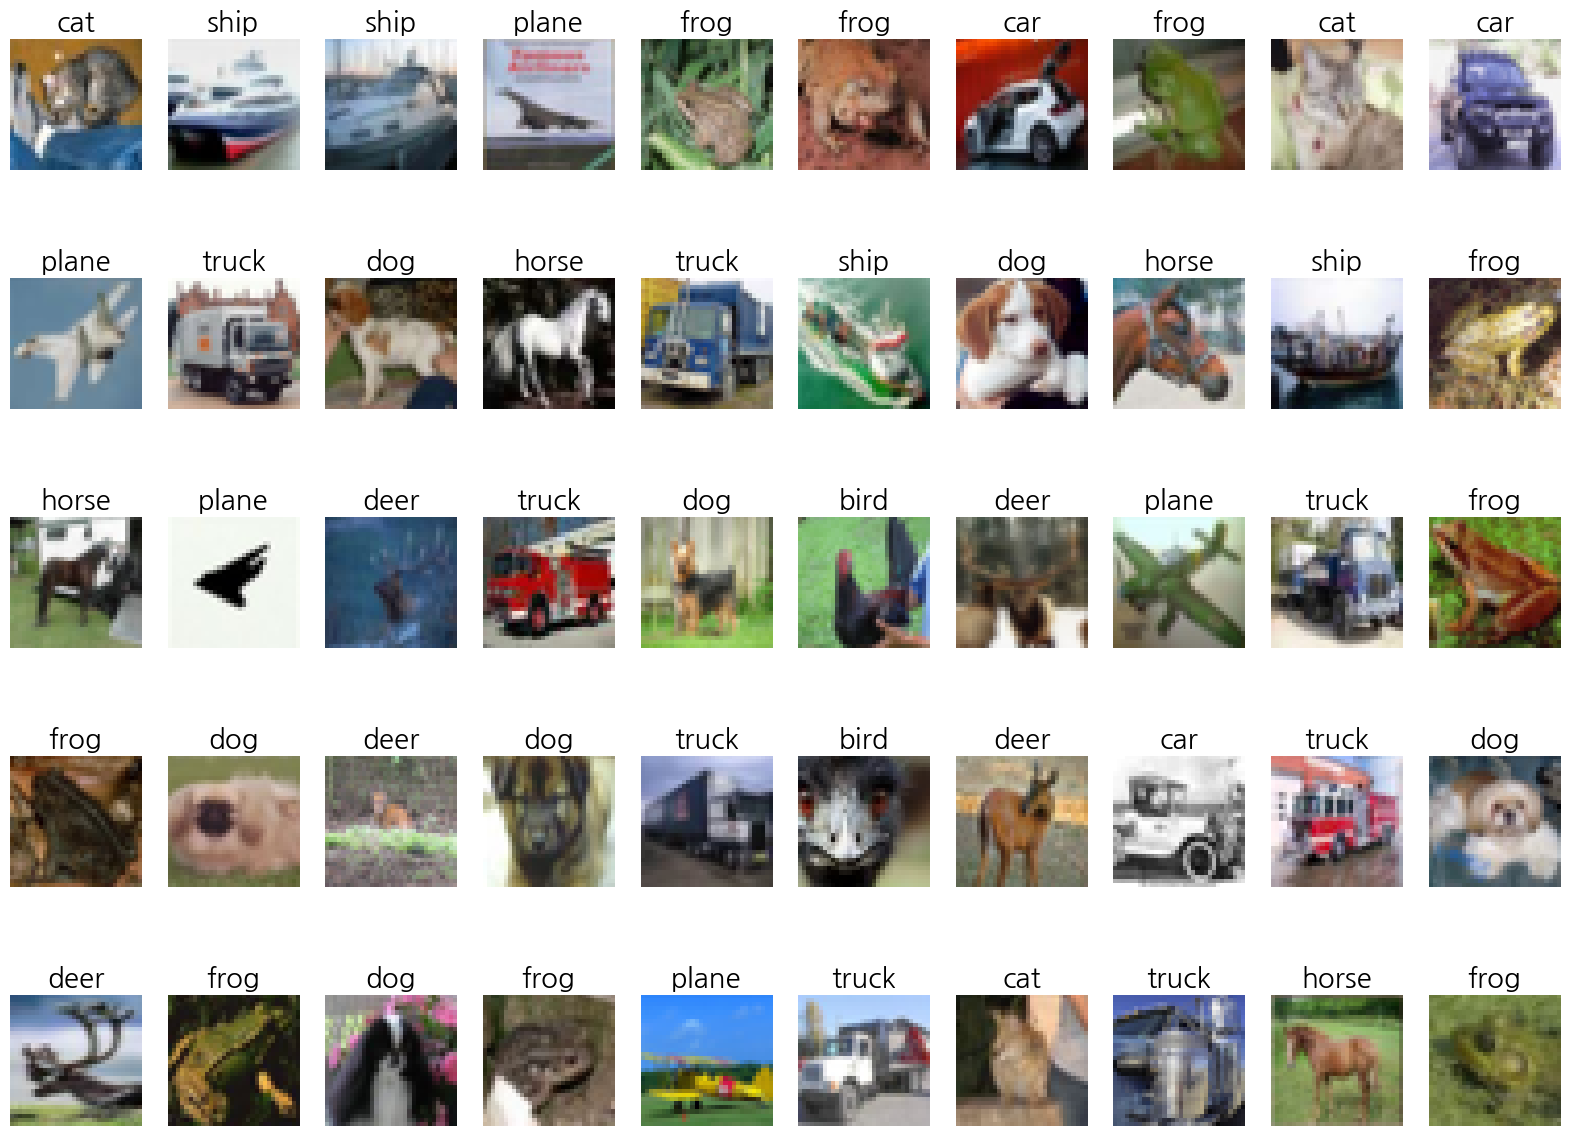

In [16]:
# 처음 50개 이미지 출력
show_images_labels(test_loader, classes, None, None)

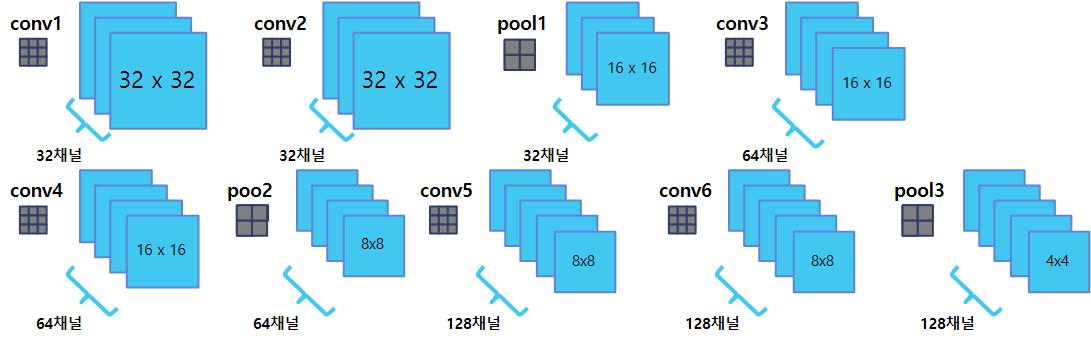  

*실습에서 구축하게 될 모델*

### 클래스 정의

In [17]:
class CNN_v2(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1)) # padding은 입력 텐서의 경계 부분을 더미 데이터로 채우는 것을 의미한다. 결과적으로 입력 텐서와 같은 요소 수를 갖는 출력 텐서를 얻게 된다.
    self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1)) # padding 옵션을 지정하지 않고 커널 사이즈 3x3의 합성곱을 적용하면, 입력 텐서보다 두 개 요소만큼 작은 텐서를 출력하게 된다.
    self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
    self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
    self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
    self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
    self.relu = nn.ReLU(inplace=True)
    self.flatten = nn.Flatten()
    self.maxpool = nn.MaxPool2d((2,2))
    self.l1 = nn.Linear(4*4*128, 128)
    self.l2 = nn.Linear(128, num_classes)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool,
        self.conv3,
        self.relu,
        self.conv4,
        self.relu,
        self.maxpool,
        self.conv5,
        self.relu,
        self.conv6,
        self.relu,
        self.maxpool
    )

    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2
    )

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

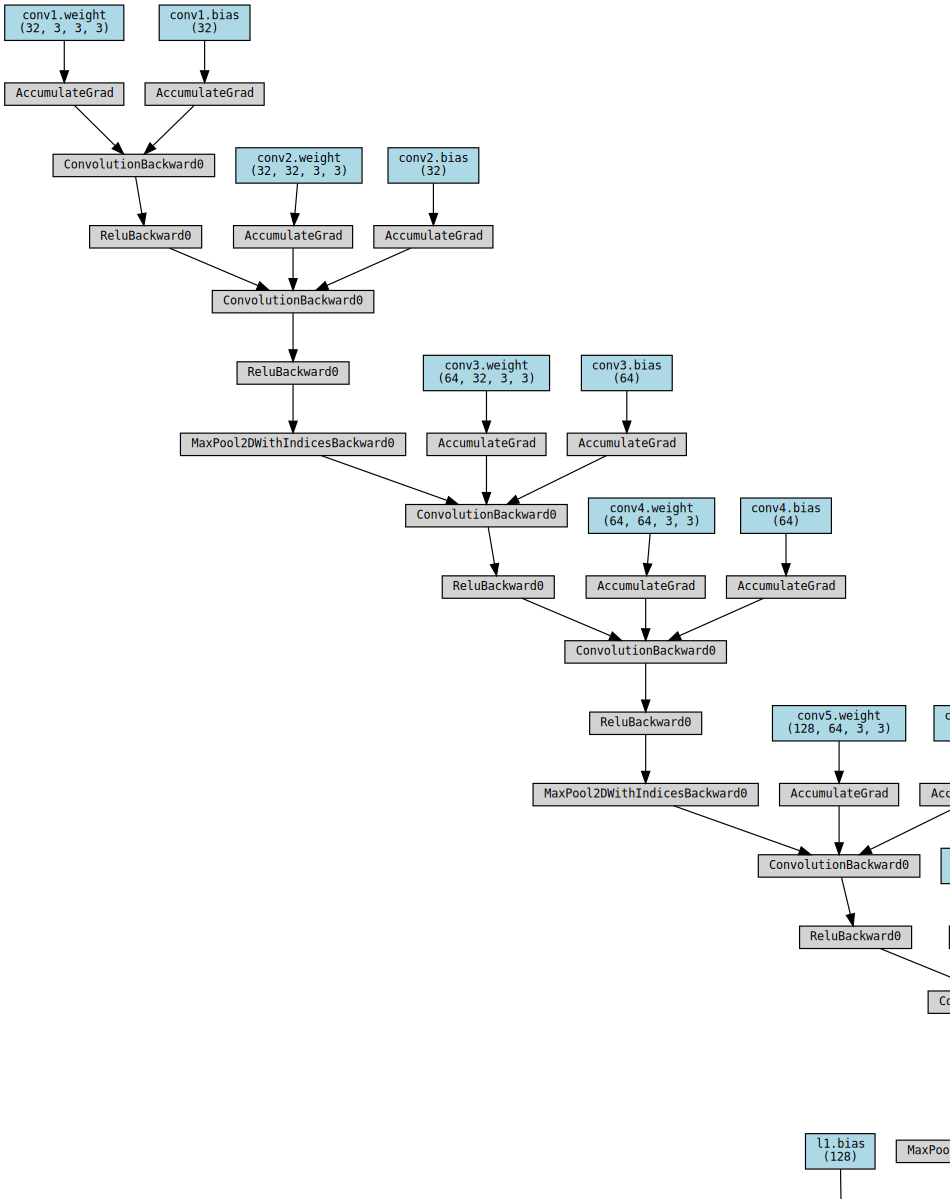

In [18]:
# 손실 계산 그래프 시각화
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 인스턴스 생성


In [19]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

### 학습

In [20]:
# 학습

num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.02303 acc: 0.10000 val_loss: 0.02303, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.02303 acc: 0.10000 val_loss: 0.02303, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.02302 acc: 0.10000 val_loss: 0.02302, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.02302 acc: 0.10844 val_loss: 0.02302, val_acc: 0.10170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.02302 acc: 0.13018 val_loss: 0.02302, val_acc: 0.17470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.02301 acc: 0.16754 val_loss: 0.02300, val_acc: 0.19080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.02298 acc: 0.18552 val_loss: 0.02294, val_acc: 0.21890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.02245 acc: 0.21920 val_loss: 0.02096, val_acc: 0.23890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.02016 acc: 0.26124 val_loss: 0.01945, val_acc: 0.29370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.01906 acc: 0.31258 val_loss: 0.01897, val_acc: 0.31170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.01796 acc: 0.35186 val_loss: 0.01700, val_acc: 0.38830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.01696 acc: 0.38414 val_loss: 0.01628, val_acc: 0.41370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.01629 acc: 0.40646 val_loss: 0.01559, val_acc: 0.42970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.01575 acc: 0.42182 val_loss: 0.01615, val_acc: 0.41590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.01530 acc: 0.43774 val_loss: 0.01506, val_acc: 0.44650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.01481 acc: 0.45852 val_loss: 0.01439, val_acc: 0.47480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.01441 acc: 0.47430 val_loss: 0.01401, val_acc: 0.48620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.01399 acc: 0.49324 val_loss: 0.01424, val_acc: 0.48570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.01355 acc: 0.51378 val_loss: 0.01337, val_acc: 0.51700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.01311 acc: 0.53180 val_loss: 0.01292, val_acc: 0.53260


반복 횟수 1-3 까지는 정확도가 10%로, 마치 무작위로 예측 한 것과 다름 없는 의미없는 모델이다.  
이는 층을 깊게 쌓았기 때문에 입력에 가까운 층까지 학습의 효과가 미치기 위해서는 더 많은 시간을 소요해야 하기 때문이라고 추측해볼 수 있다.

초기상태 : 손실 : 0.02303  정확도 : 0.10000
최종상태 : 손실 : 0.01292 정확도 : 0.53260


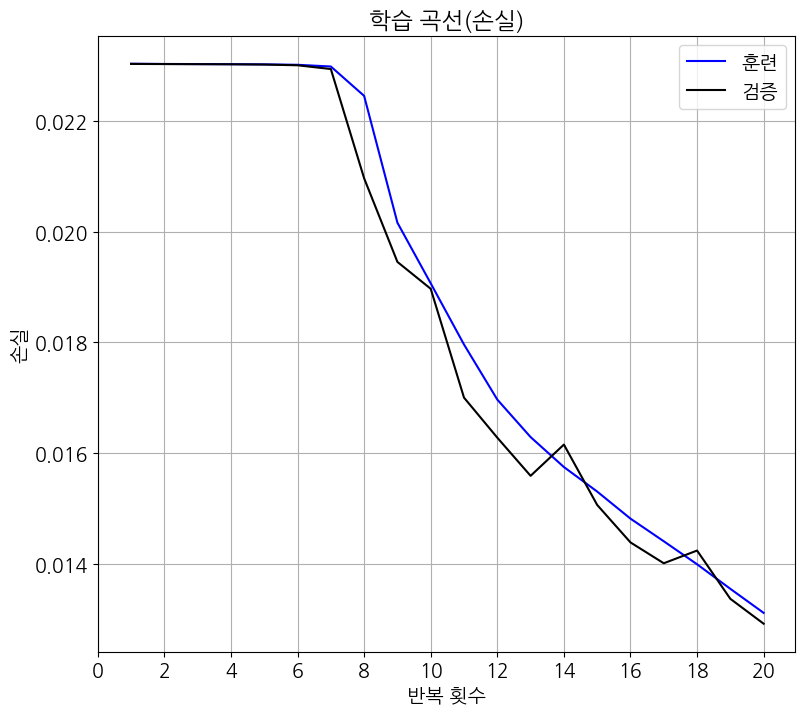

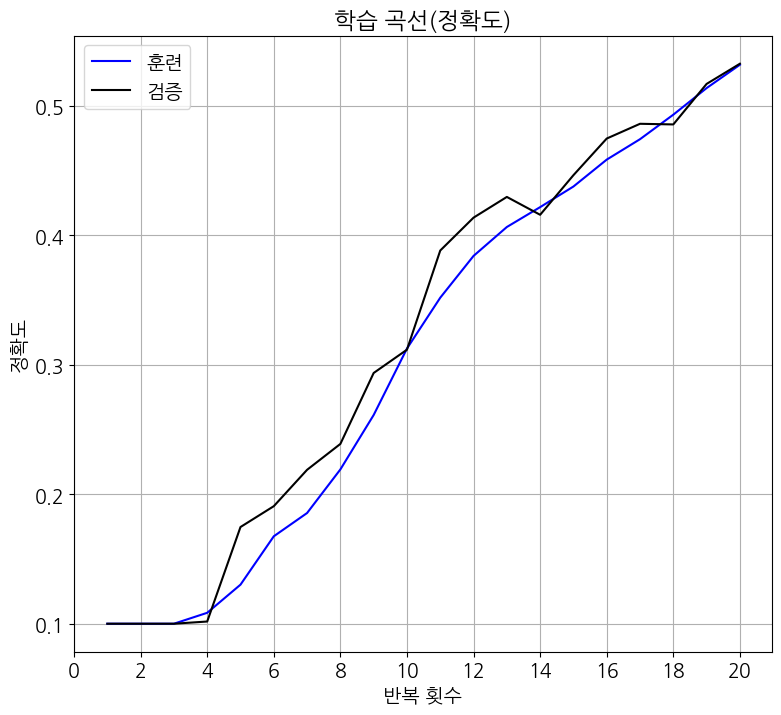

In [21]:
evaluate_history(history)

## 10.7 최적화 함수 선택

모멘텀 값 설정

In [22]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()

# 최적화 함수에 모멘텀 값 설정
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history = np.zeros((0, 5))

In [23]:
# 학습

num_epochs = 20
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.02283 acc: 0.12340 val_loss: 0.02041, val_acc: 0.25260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.01798 acc: 0.33730 val_loss: 0.01539, val_acc: 0.42420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.01409 acc: 0.48280 val_loss: 0.01270, val_acc: 0.54520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.01165 acc: 0.58234 val_loss: 0.01080, val_acc: 0.61500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.00975 acc: 0.65238 val_loss: 0.00906, val_acc: 0.67980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00824 acc: 0.70934 val_loss: 0.00852, val_acc: 0.70030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00688 acc: 0.75736 val_loss: 0.00775, val_acc: 0.73330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00587 acc: 0.79574 val_loss: 0.00747, val_acc: 0.74740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00500 acc: 0.82490 val_loss: 0.00739, val_acc: 0.75110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00419 acc: 0.85274 val_loss: 0.00735, val_acc: 0.76040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00345 acc: 0.87774 val_loss: 0.00759, val_acc: 0.76370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00283 acc: 0.89874 val_loss: 0.00752, val_acc: 0.77210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00235 acc: 0.91642 val_loss: 0.00853, val_acc: 0.76440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00200 acc: 0.92900 val_loss: 0.00871, val_acc: 0.76190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00162 acc: 0.94182 val_loss: 0.01030, val_acc: 0.77140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00145 acc: 0.94818 val_loss: 0.01038, val_acc: 0.76310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00130 acc: 0.95372 val_loss: 0.01246, val_acc: 0.74310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00097 acc: 0.96632 val_loss: 0.01301, val_acc: 0.74930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00100 acc: 0.96556 val_loss: 0.01230, val_acc: 0.75940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00091 acc: 0.96840 val_loss: 0.01283, val_acc: 0.76760


초기상태 : 손실 : 0.02041  정확도 : 0.25260
최종상태 : 손실 : 0.01283 정확도 : 0.76760


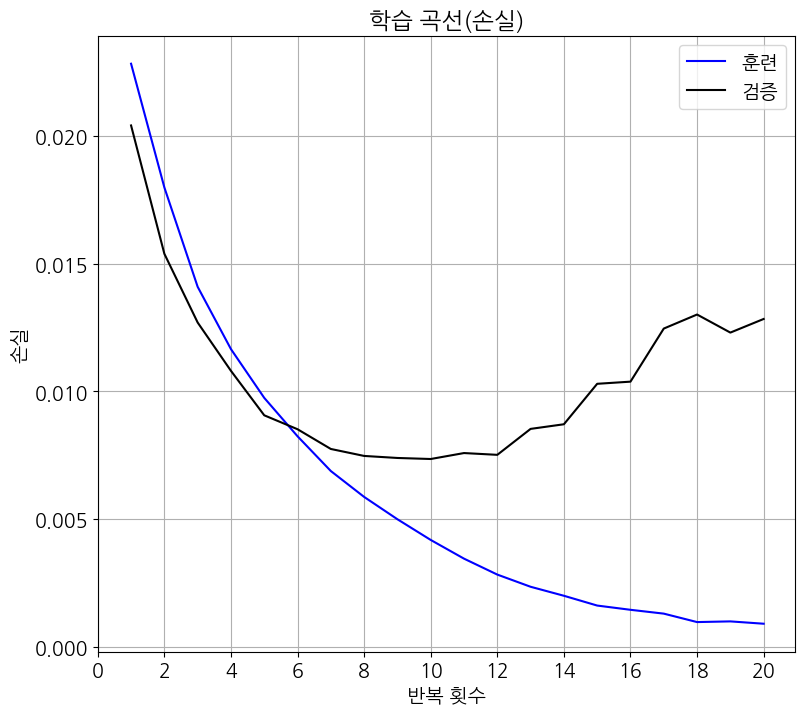

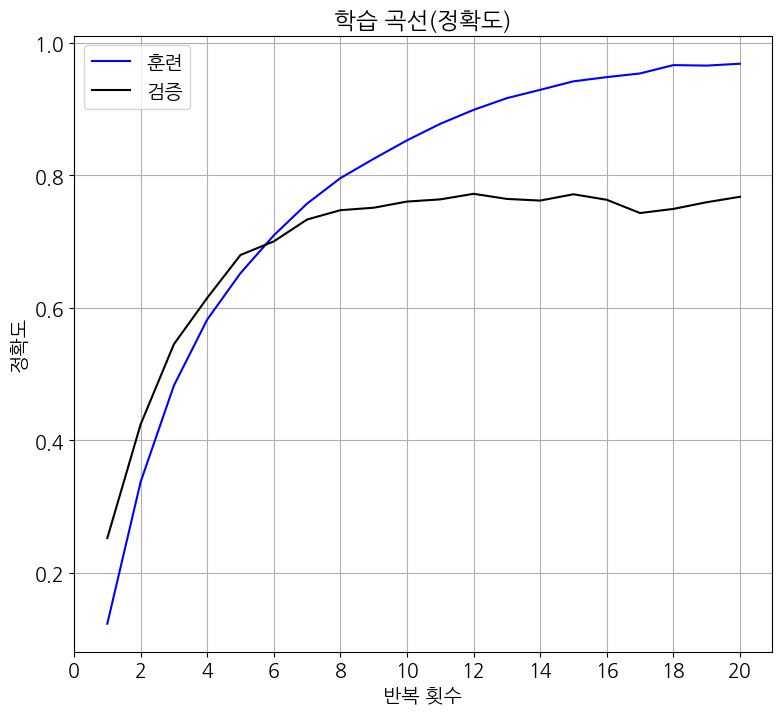

In [24]:
evaluate_history(history2)

최적화 함수를 Adam으로 교체

In [25]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()

# 최적화 함수를 Adam으로 교체
optimizer = optim.Adam(net.parameters())
history3 = np.zeros((0, 5))

In [26]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [27]:
# 학습

num_epochs = 20
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.01588 acc: 0.41740 val_loss: 0.01245, val_acc: 0.55050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.01083 acc: 0.61086 val_loss: 0.00985, val_acc: 0.65380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.00861 acc: 0.69488 val_loss: 0.00851, val_acc: 0.70520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.00706 acc: 0.74966 val_loss: 0.00791, val_acc: 0.72520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.00599 acc: 0.78874 val_loss: 0.00693, val_acc: 0.76210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00502 acc: 0.82172 val_loss: 0.00706, val_acc: 0.76670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00420 acc: 0.85138 val_loss: 0.00710, val_acc: 0.76740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00344 acc: 0.87960 val_loss: 0.00765, val_acc: 0.76250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00276 acc: 0.90240 val_loss: 0.00840, val_acc: 0.75960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00232 acc: 0.91560 val_loss: 0.00896, val_acc: 0.76640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00185 acc: 0.93434 val_loss: 0.00939, val_acc: 0.77250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00154 acc: 0.94678 val_loss: 0.01052, val_acc: 0.75100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00134 acc: 0.95186 val_loss: 0.01097, val_acc: 0.76380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00120 acc: 0.95778 val_loss: 0.01196, val_acc: 0.77000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00109 acc: 0.96168 val_loss: 0.01271, val_acc: 0.76670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00097 acc: 0.96666 val_loss: 0.01266, val_acc: 0.76470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00097 acc: 0.96648 val_loss: 0.01277, val_acc: 0.75750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00081 acc: 0.97102 val_loss: 0.01378, val_acc: 0.76540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00092 acc: 0.96756 val_loss: 0.01439, val_acc: 0.76450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00090 acc: 0.96922 val_loss: 0.01447, val_acc: 0.74640


초기상태 : 손실 : 0.01245  정확도 : 0.55050
최종상태 : 손실 : 0.01447 정확도 : 0.74640


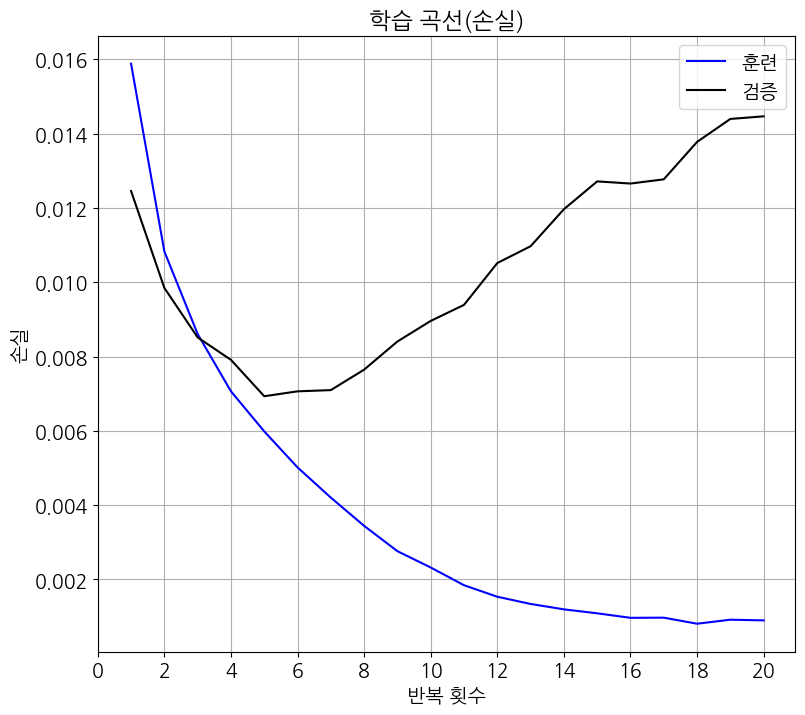

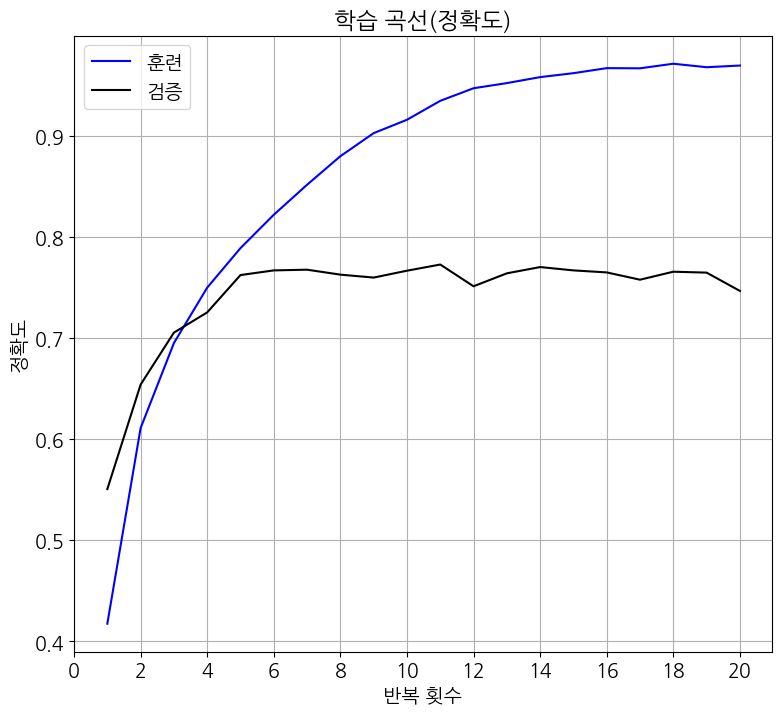

In [28]:
evaluate_history(history3)

**결과 비교**

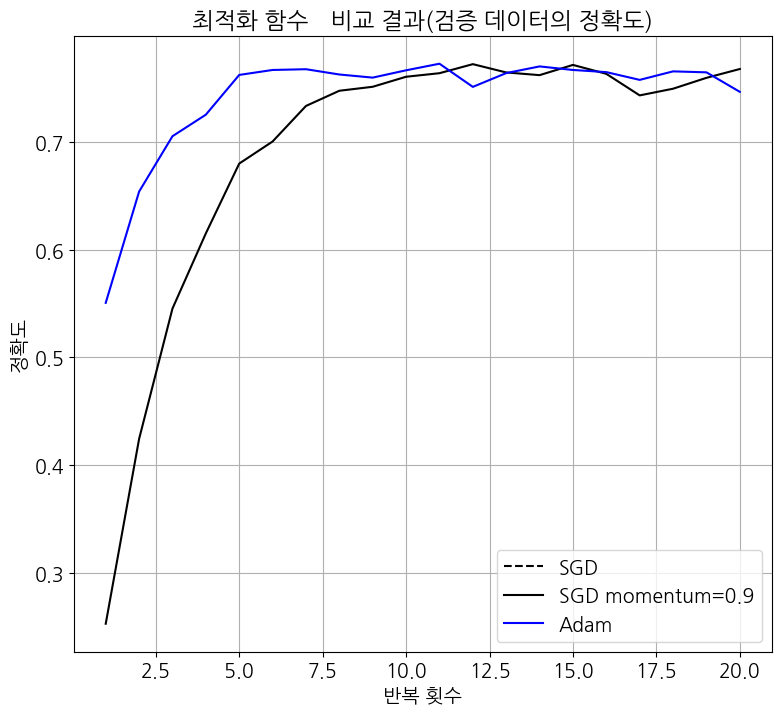

In [29]:
# 결과 비교(검증 데이터의 정확도)
plt.figure(figsize=(9,8))
plt.plot(history[:,0], history[:,4], label='SGD', c='k',ls='dashed' )
plt.plot(history2[:,0], history2[:,4], label='SGD momentum=0.9', c='k')
plt.plot(history3[:,0], history3[:,4], label='Adam', c='b')
plt.title('최적화 함수　비교 결과(검증 데이터의 정확도)')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.legend()
plt.show()

## 10.8 드롭아웃

In [30]:
# 모델 정의

class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

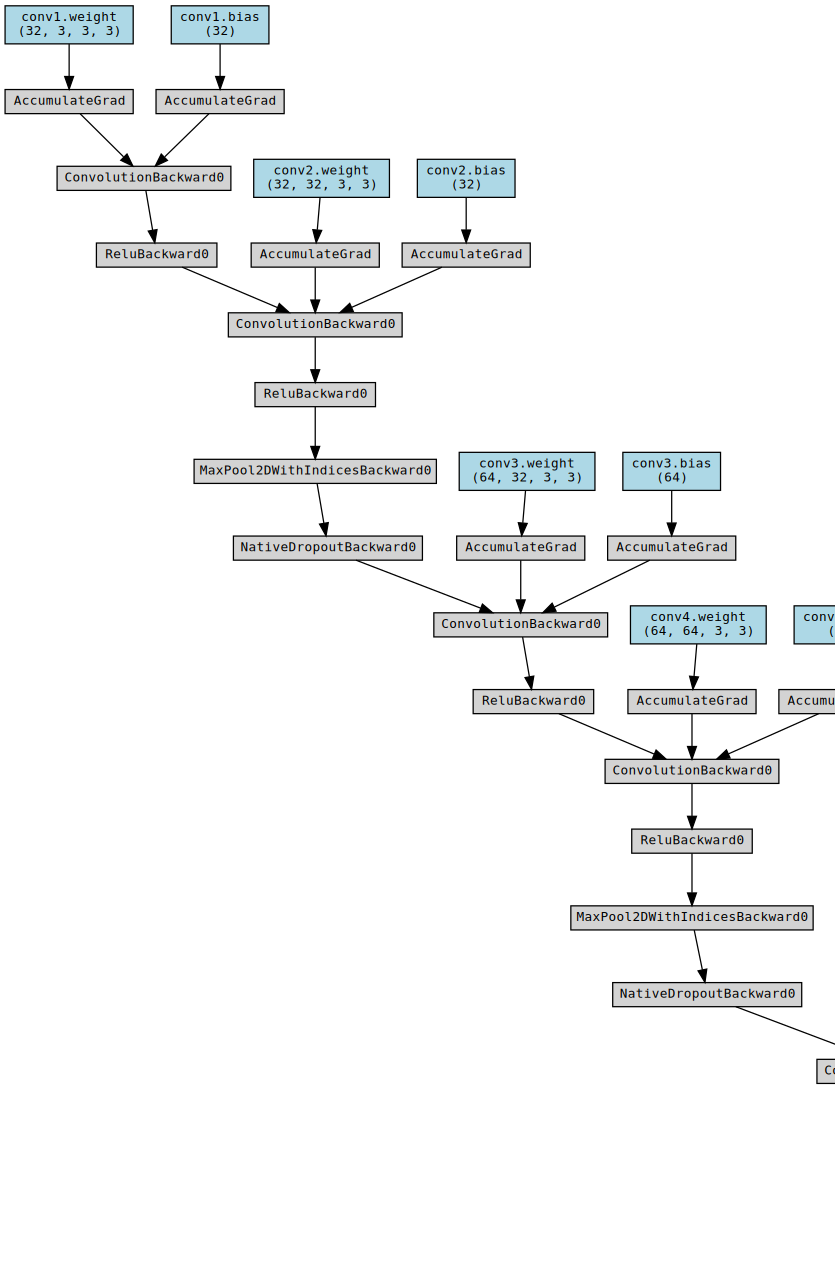

In [31]:
# 손실 계산 그래프 시각화
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [32]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [33]:
# 학습

num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.01704 acc: 0.36520 val_loss: 0.01306, val_acc: 0.51760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.01278 acc: 0.53528 val_loss: 0.01092, val_acc: 0.60240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.01118 acc: 0.59952 val_loss: 0.01025, val_acc: 0.63920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.01002 acc: 0.64254 val_loss: 0.00853, val_acc: 0.70010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.00911 acc: 0.67918 val_loss: 0.00790, val_acc: 0.71830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00839 acc: 0.70728 val_loss: 0.00751, val_acc: 0.74020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00783 acc: 0.72932 val_loss: 0.00713, val_acc: 0.75400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00749 acc: 0.74116 val_loss: 0.00688, val_acc: 0.76040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00711 acc: 0.75468 val_loss: 0.00662, val_acc: 0.76760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00681 acc: 0.76590 val_loss: 0.00656, val_acc: 0.77390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00651 acc: 0.77234 val_loss: 0.00673, val_acc: 0.77000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00637 acc: 0.77810 val_loss: 0.00610, val_acc: 0.79540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00612 acc: 0.78794 val_loss: 0.00595, val_acc: 0.79820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00590 acc: 0.79460 val_loss: 0.00590, val_acc: 0.80000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00581 acc: 0.79852 val_loss: 0.00584, val_acc: 0.80530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00567 acc: 0.80274 val_loss: 0.00554, val_acc: 0.81420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00557 acc: 0.80700 val_loss: 0.00576, val_acc: 0.80770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00544 acc: 0.81460 val_loss: 0.00563, val_acc: 0.80910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00534 acc: 0.81642 val_loss: 0.00547, val_acc: 0.81650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00525 acc: 0.81896 val_loss: 0.00566, val_acc: 0.81030


초기상태 : 손실 : 0.01306  정확도 : 0.51760
최종상태 : 손실 : 0.00566 정확도 : 0.81030


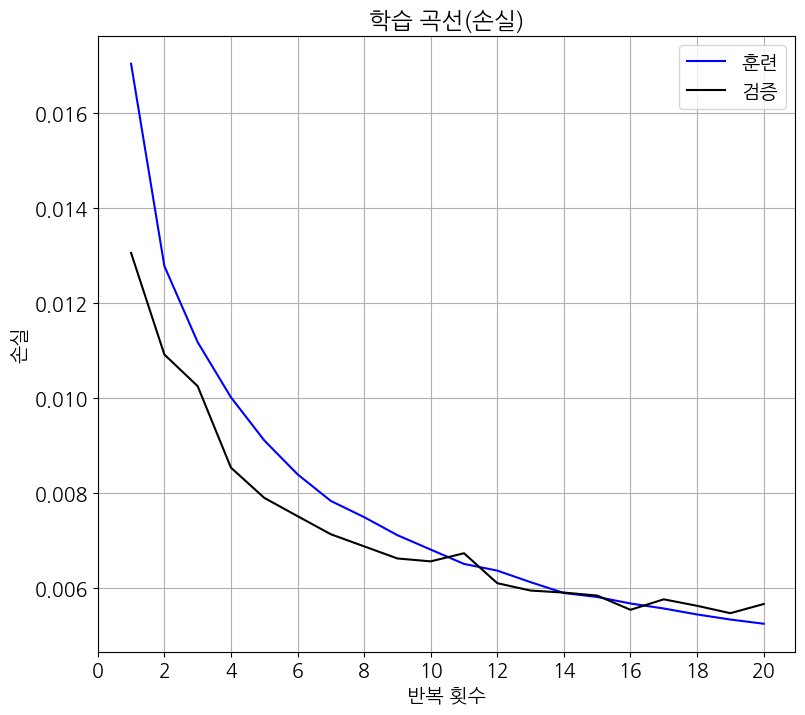

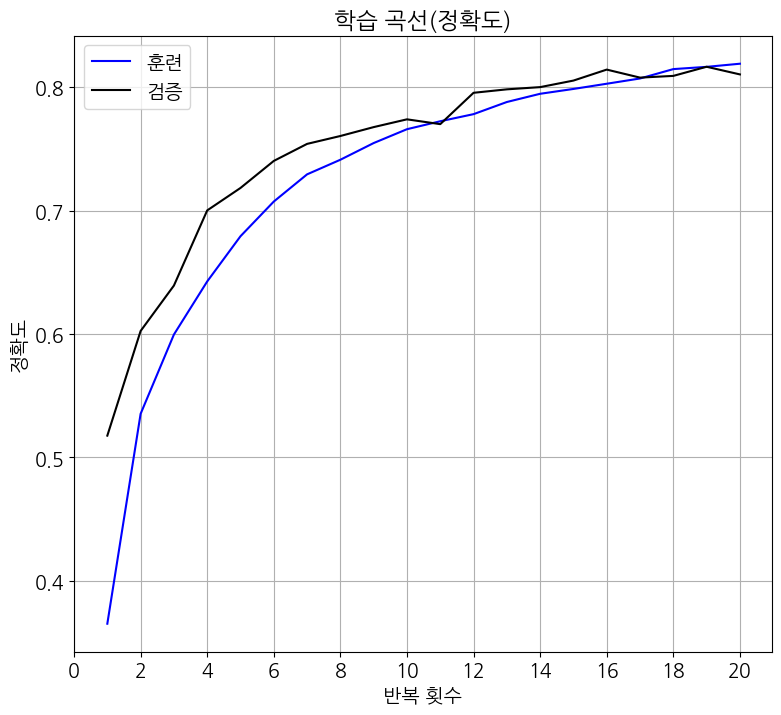

In [34]:
evaluate_history(history)

드롭아웃 사용 시, 과학습에 대해 분명 강한 효과가 있지만, 학습에 소요되는 시간이 길어진다.

## 10.9 배치 정규화

nn.BatchNorm2d(이미지의 채널수)  
BN 함수는 자기 자신도 파라미터를 가지고 있으며 학습 대상의 일부이다. 따라서, 인스턴스 변수를 정의할 때는 채널 수가 동일하다고 해서 같은 변수를 사용하는 것은 좋지 않다. (bn1과 bn2를 bn 하나로 사용하는 것).  
따라서, 사용해야할 곳마다 별개의 인스턴스를 정의해야 한다.

In [35]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [36]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [37]:
# 학습

num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.01511 acc: 0.44134 val_loss: 0.01155, val_acc: 0.57880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.01147 acc: 0.58994 val_loss: 0.01153, val_acc: 0.58770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.00999 acc: 0.64932 val_loss: 0.00836, val_acc: 0.70910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.00904 acc: 0.68558 val_loss: 0.00733, val_acc: 0.73690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.00844 acc: 0.70890 val_loss: 0.00706, val_acc: 0.75640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00784 acc: 0.73112 val_loss: 0.00698, val_acc: 0.76180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00751 acc: 0.74288 val_loss: 0.00627, val_acc: 0.77900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00711 acc: 0.75850 val_loss: 0.00587, val_acc: 0.79730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00674 acc: 0.77098 val_loss: 0.00567, val_acc: 0.80570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00646 acc: 0.78296 val_loss: 0.00548, val_acc: 0.81210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00616 acc: 0.79188 val_loss: 0.00513, val_acc: 0.82660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00597 acc: 0.79946 val_loss: 0.00525, val_acc: 0.82400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00565 acc: 0.80882 val_loss: 0.00505, val_acc: 0.83390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00547 acc: 0.81494 val_loss: 0.00491, val_acc: 0.83470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00525 acc: 0.82154 val_loss: 0.00512, val_acc: 0.83080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00510 acc: 0.82902 val_loss: 0.00467, val_acc: 0.84410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00493 acc: 0.83500 val_loss: 0.00479, val_acc: 0.84110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00475 acc: 0.84116 val_loss: 0.00446, val_acc: 0.85130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00459 acc: 0.84418 val_loss: 0.00465, val_acc: 0.84700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00443 acc: 0.85044 val_loss: 0.00460, val_acc: 0.84990


초기상태 : 손실 : 0.01155  정확도 : 0.57880
최종상태 : 손실 : 0.00460 정확도 : 0.84990


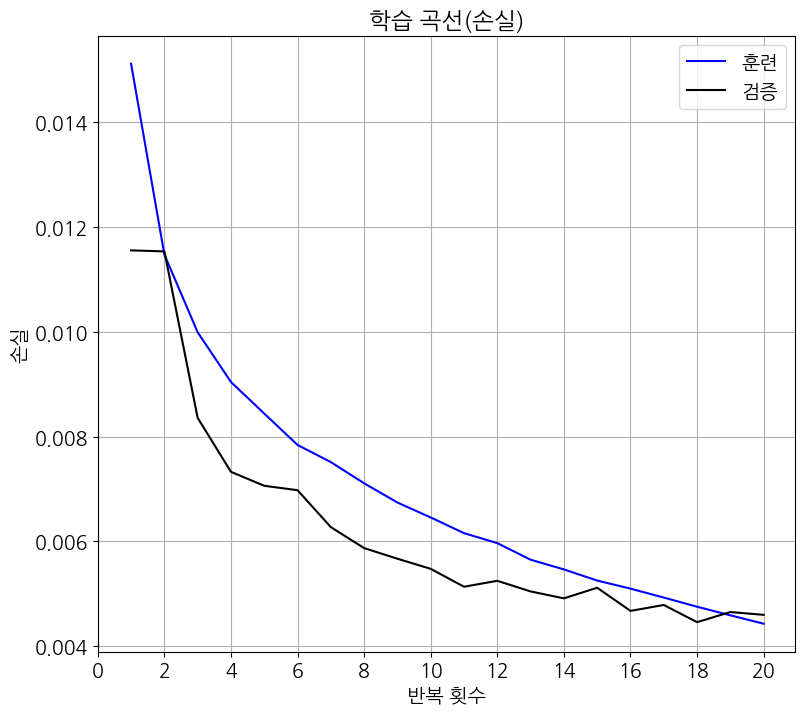

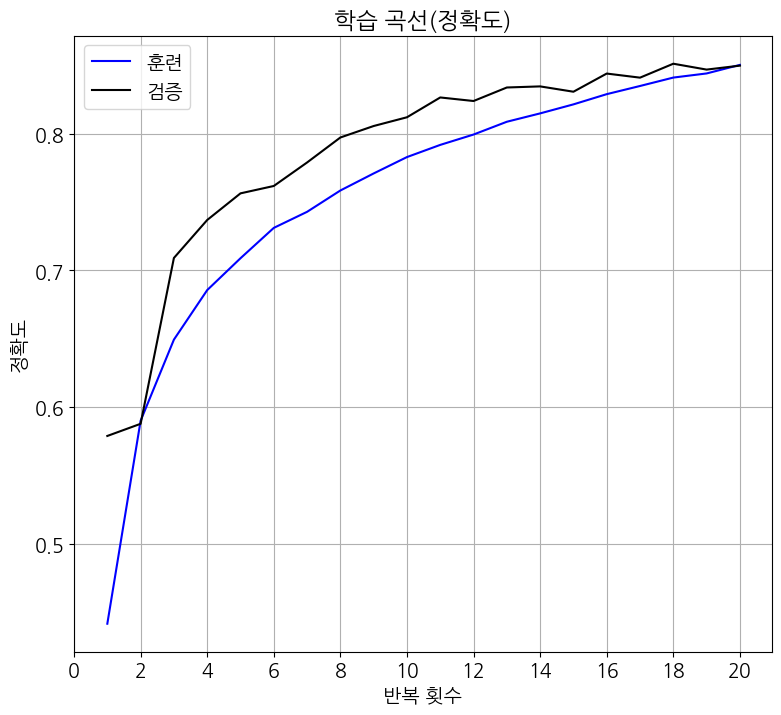

In [38]:
evaluate_history(history)

## 10.10 데이터 증강 기법

데이터 증강 기법(transforms)은 드롭아웃과 마찬가지로, 반복횟수가 더 많아야 한다.(= 학습시간이 더 많이 소요된다)

In [39]:
# 훈련 데이터용: 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [40]:
# transfrom_train을 사용한 데이터셋 정의
train_set2 = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

# traisform_train을 사용한 데이터로더 정의
batch_size = 100
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


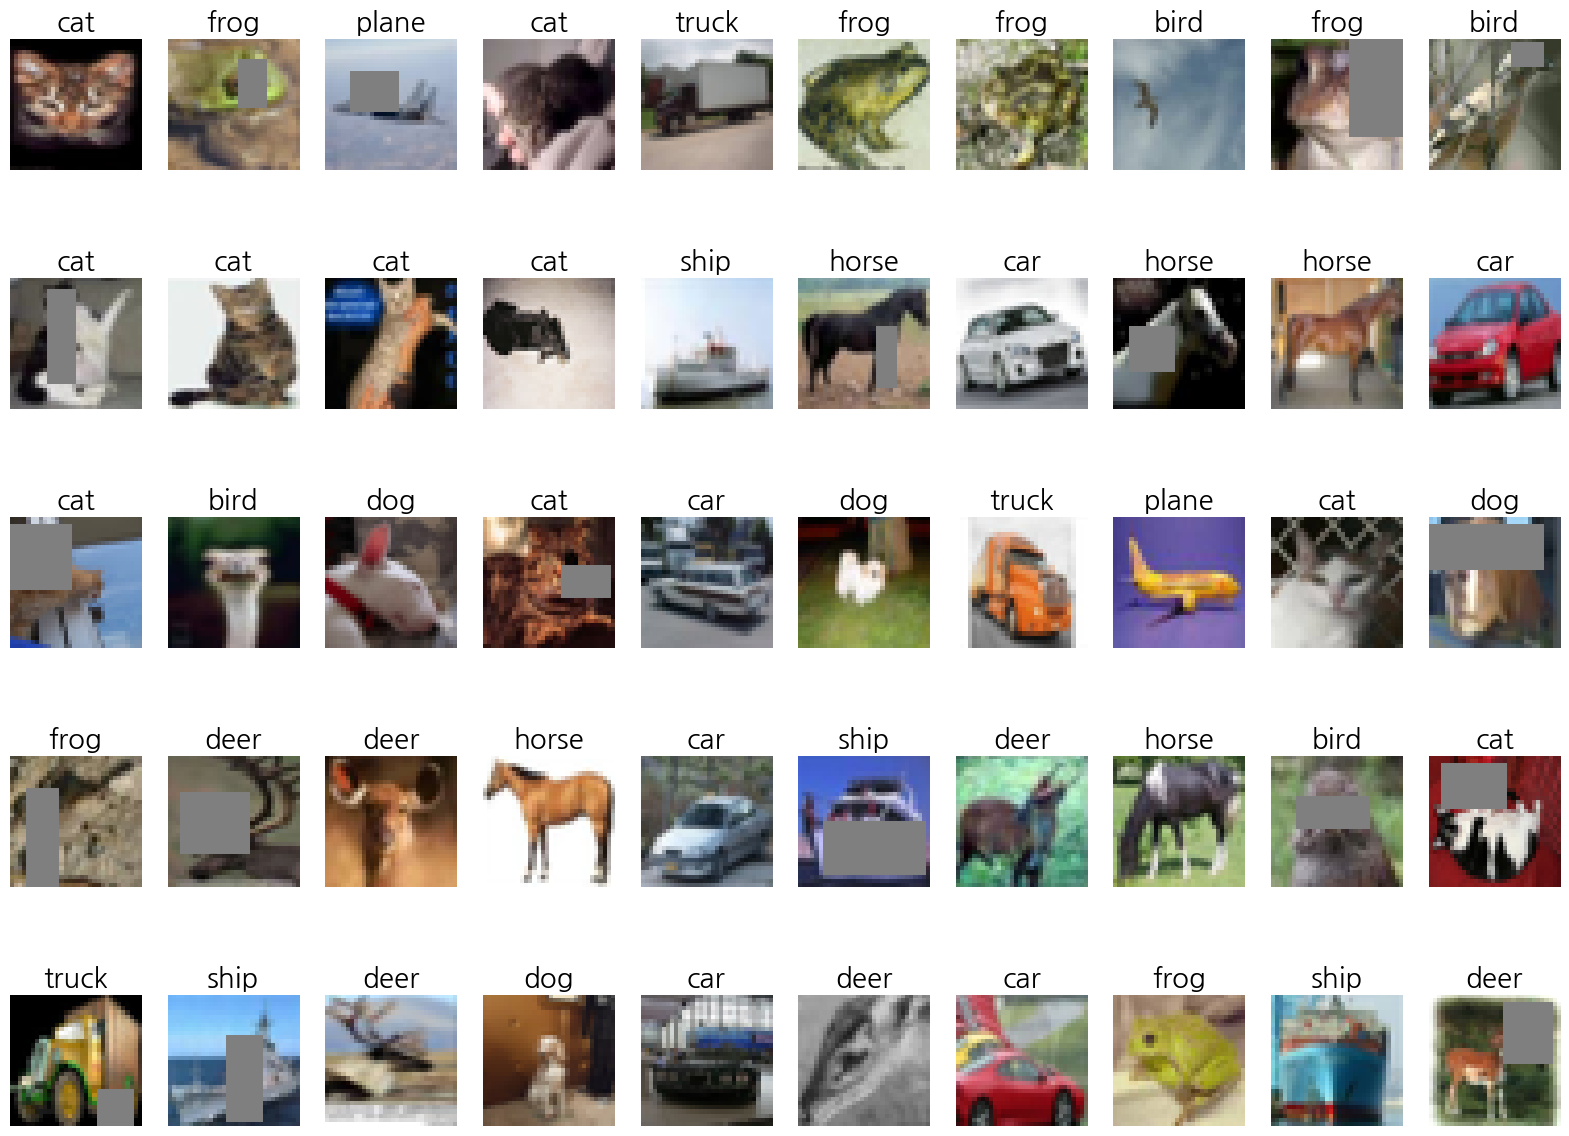

In [41]:
# 새로운 훈련 데이터의 처음 50개 표시

# 난수 고정
torch_seed()

show_images_labels(train_loader2, classes, None, None)

In [42]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [43]:
# 학습
# 동일한 모델에서 train_loader2로 데이터를 변경

num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs,
        train_loader2, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.01607 acc: 0.40540 val_loss: 0.01181, val_acc: 0.57070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.01271 acc: 0.54666 val_loss: 0.01137, val_acc: 0.60460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.01124 acc: 0.60266 val_loss: 0.00881, val_acc: 0.67890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.01042 acc: 0.63608 val_loss: 0.00789, val_acc: 0.71890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.00984 acc: 0.65900 val_loss: 0.00775, val_acc: 0.72440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00946 acc: 0.67294 val_loss: 0.00736, val_acc: 0.74170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00906 acc: 0.68712 val_loss: 0.00699, val_acc: 0.75430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00877 acc: 0.69738 val_loss: 0.00671, val_acc: 0.76480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00844 acc: 0.70986 val_loss: 0.00629, val_acc: 0.77910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00819 acc: 0.72092 val_loss: 0.00588, val_acc: 0.80000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00799 acc: 0.72802 val_loss: 0.00610, val_acc: 0.79000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00776 acc: 0.73640 val_loss: 0.00563, val_acc: 0.80420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00762 acc: 0.74266 val_loss: 0.00558, val_acc: 0.80600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00747 acc: 0.74682 val_loss: 0.00552, val_acc: 0.81090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00723 acc: 0.75456 val_loss: 0.00525, val_acc: 0.81710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00712 acc: 0.75928 val_loss: 0.00516, val_acc: 0.82200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00694 acc: 0.76618 val_loss: 0.00507, val_acc: 0.82660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00688 acc: 0.76536 val_loss: 0.00513, val_acc: 0.82710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00672 acc: 0.77578 val_loss: 0.00495, val_acc: 0.83110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00666 acc: 0.77578 val_loss: 0.00488, val_acc: 0.82830


초기상태 : 손실 : 0.01181  정확도 : 0.57070
최종상태 : 손실 : 0.00488 정확도 : 0.82830


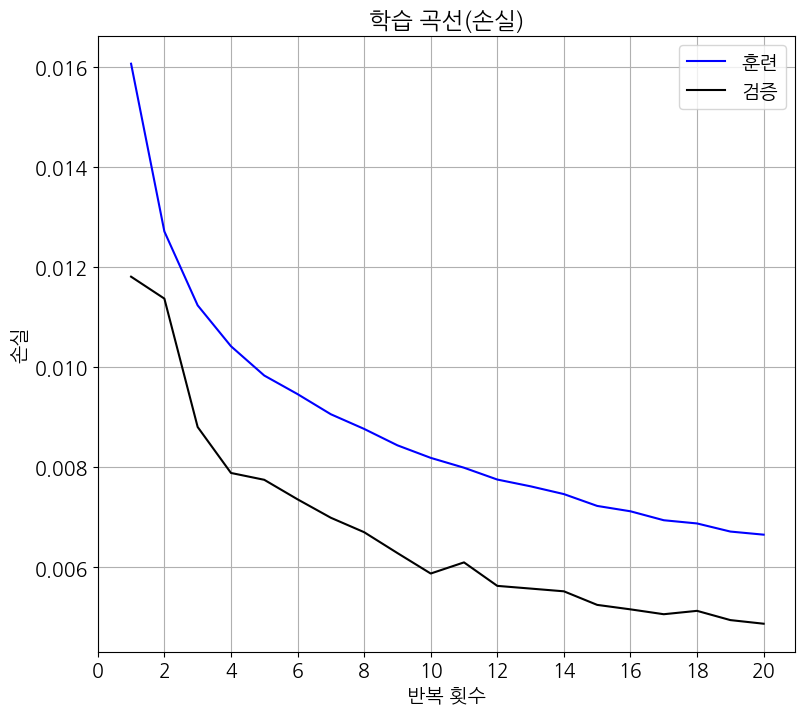

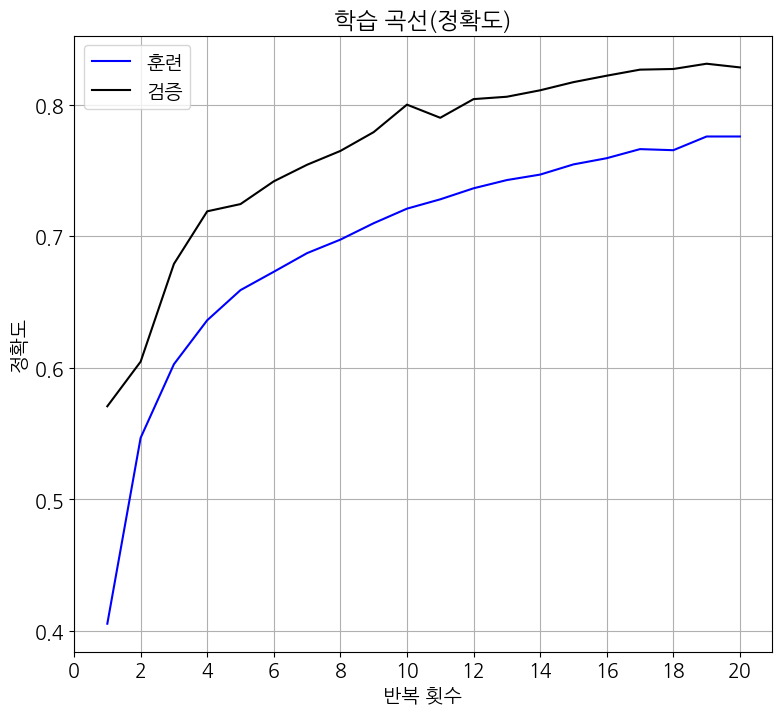

In [44]:
evaluate_history(history)

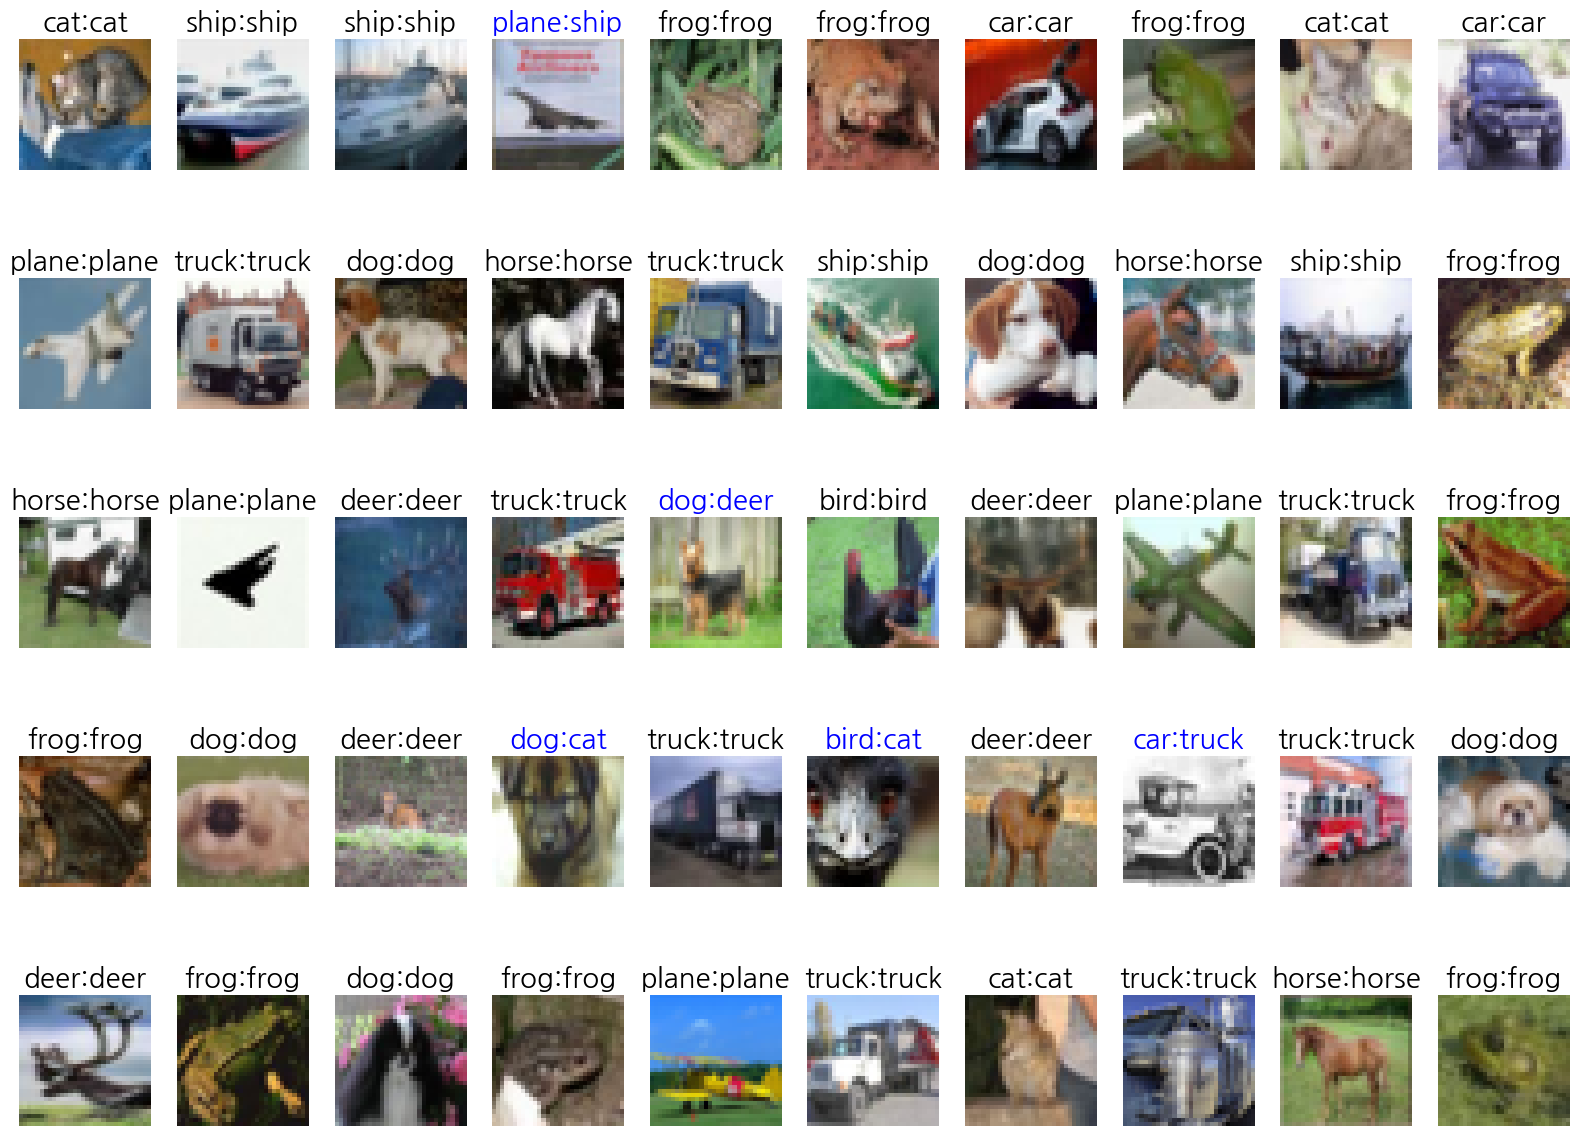

In [45]:
show_images_labels(test_loader, classes, net, device)

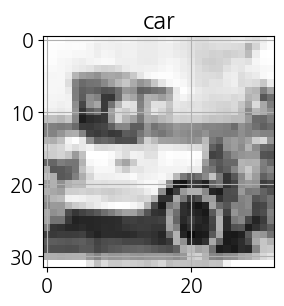

In [46]:
# 잘못 예측한 38번째 데이터 추출
for images, labels in test_loader:
    break
image = images[37]
label = labels[37]

# 이미지 확인
plt.figure(figsize=(3,3))
w = image.numpy().copy()
w2 = np.transpose(w, (1, 2, 0))
w3 = (w2 + 1)/2
plt.title(classes[label])
plt.imshow(w3)
plt.show()

In [47]:
# 예측 값 출력
image = image.view(1, 3, 32, 32)
image = image.to(device)
output = net(image)

# 라벨 별 확률 값 출력
probs = torch.softmax(output, dim=1)
probs_np = probs.data.to('cpu').numpy()[0]
values = np.frompyfunc(lambda x: f'{x:.04f}', 1, 1)(probs_np)
names = np.array(classes)
tbl = np.array([names, values]).T
print(tbl)

## 파이토치의 경우, 케라스와 달리 모델의 출력 그 자체가 확률 값을 의미하지는 않지만, 이런 방식으로 소프트맥스 함수를 적용하면 확률 값을 얻어낼 수 있다.

[['plane' '0.0023']
 ['car' '0.1104']
 ['bird' '0.0000']
 ['cat' '0.0000']
 ['deer' '0.0000']
 ['dog' '0.0000']
 ['frog' '0.0000']
 ['horse' '0.0000']
 ['ship' '0.0033']
 ['truck' '0.8839']]


### 칼럼 배치 정규화를 사용할 때 주의할 점

In [48]:
# 잘못된 모델 클래스 정의의 예시
class CNN_v5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1, # 같은 BN 인스턴스 사용
            self.relu,
            self.conv2,
            self.bn1, # 같은 BN 인스턴스 사용
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn2,
            self.relu,
            self.conv4,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn3,
            self.relu,
            self.conv6,
            self.bn3,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [49]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [50]:
# 학습

num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.01500 acc: 0.44840 val_loss: 0.02297, val_acc: 0.24460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.01126 acc: 0.59930 val_loss: 0.02462, val_acc: 0.12810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.00979 acc: 0.65764 val_loss: 0.02401, val_acc: 0.14020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.00884 acc: 0.69430 val_loss: 0.02879, val_acc: 0.16770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.00825 acc: 0.71804 val_loss: 0.02795, val_acc: 0.13790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00771 acc: 0.73842 val_loss: 0.03579, val_acc: 0.14540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00734 acc: 0.74990 val_loss: 0.04012, val_acc: 0.11280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00692 acc: 0.76428 val_loss: 0.03378, val_acc: 0.12500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00660 acc: 0.77896 val_loss: 0.02925, val_acc: 0.11980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00633 acc: 0.78822 val_loss: 0.02920, val_acc: 0.14320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00598 acc: 0.79802 val_loss: 0.03020, val_acc: 0.13560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00582 acc: 0.80484 val_loss: 0.03013, val_acc: 0.13850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00556 acc: 0.81542 val_loss: 0.02892, val_acc: 0.13310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00538 acc: 0.82030 val_loss: 0.03371, val_acc: 0.11020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00521 acc: 0.82462 val_loss: 0.03039, val_acc: 0.14080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00508 acc: 0.82984 val_loss: 0.02895, val_acc: 0.11770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00489 acc: 0.83684 val_loss: 0.03958, val_acc: 0.12670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00479 acc: 0.83972 val_loss: 0.03607, val_acc: 0.12720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00463 acc: 0.84550 val_loss: 0.03514, val_acc: 0.10270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00451 acc: 0.84812 val_loss: 0.04330, val_acc: 0.13770


학습이 전혀 되고 있지 않음

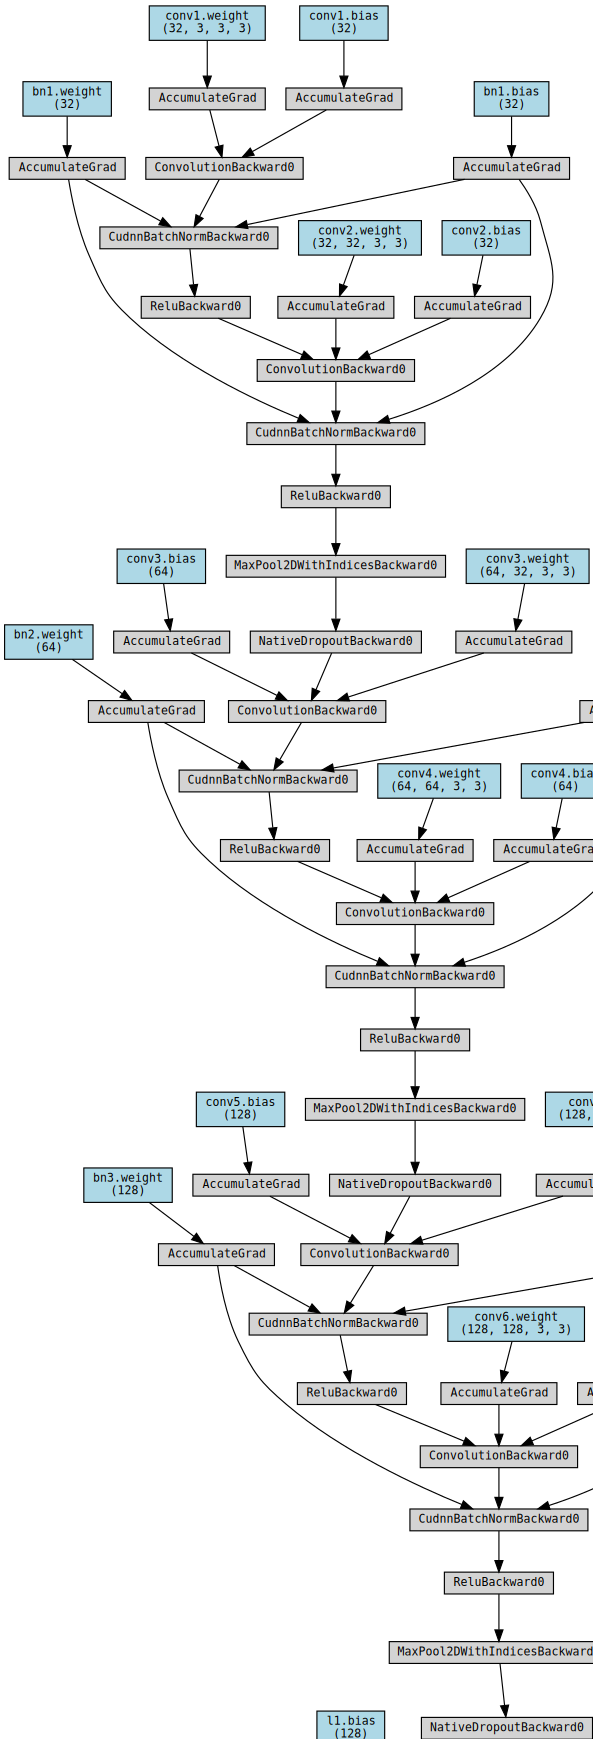

In [51]:
# 손실 계산 그래프 시각화
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

지금껏 보지 못했던 양쪽 노드가 보임. 내부에 파라미터를 가진 함수를 두 군데에서 같이 사용해서 양다리 형태의 그래프가 형성된 것이다.